In [3]:
import os
import random

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

from AADB.AADB import AADB, AADB_classes
from tqdm import tqdm
from utils.utils import *
from models.ResNet18 import RegressionNetwork
from loss_functions.rank_loss import RegRankLoss

### Variables

In [3]:
batch_size = 32
epochs = 200
load = False
ckpt = 'F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt_2_pretrained\AADB_epoch_100_loss_0.0702_.pt'

In [4]:
image_dir = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\ImageAesthetics_ECCV2016\datasetImages_warp256'
label_csv_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'

### AADB

In [5]:
aadb = AADB_classes(image_dir, label_csv_path)  #, drop_score=False)
aadb_test = AADB_classes(image_dir, label_csv_path) #, test=True, drop_score=False)

tensor([2., 3., 2., 1., 2., 2., 1., 0., 1., 0., 2.], dtype=torch.float64)


8958

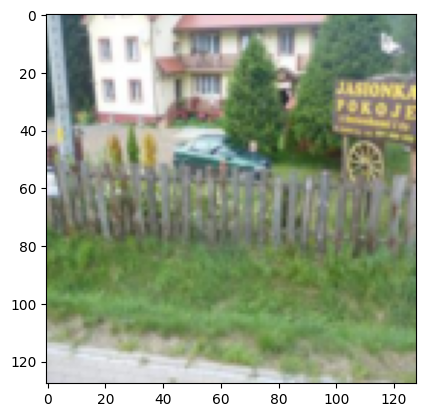

In [6]:
show_example(*aadb[0])
len(aadb)

tensor([ 0.0000,  0.8000,  0.6000,  0.6000, -0.2000,  0.0000,  0.8000,  0.0000,
         0.0000,  0.0000, -0.2000,  0.6500], dtype=torch.float64)


1000

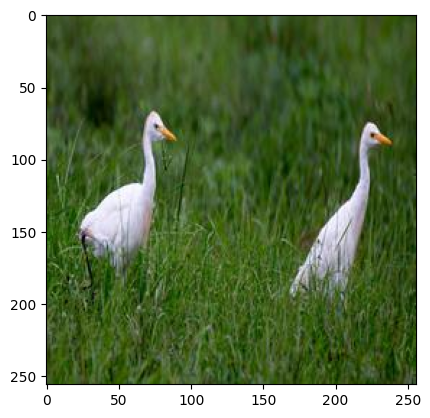

In [33]:
show_example(*aadb_test[0])
len(aadb_test)

### DataLoaders

In [34]:
val_size = 500
train_size = len(aadb) - val_size

train_ds, val_ds = random_split(aadb, [train_size, val_size])
len(train_ds), len(val_ds)

(8458, 500)

In [35]:
train_dl = DataLoader(train_ds, batch_size*2, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)

In [36]:
print(len(train_dl))
print(len(valid_dl))

132
16


In [37]:
for image, _ in train_dl:
    print(image.shape)
    break

torch.Size([64, 3, 256, 256])


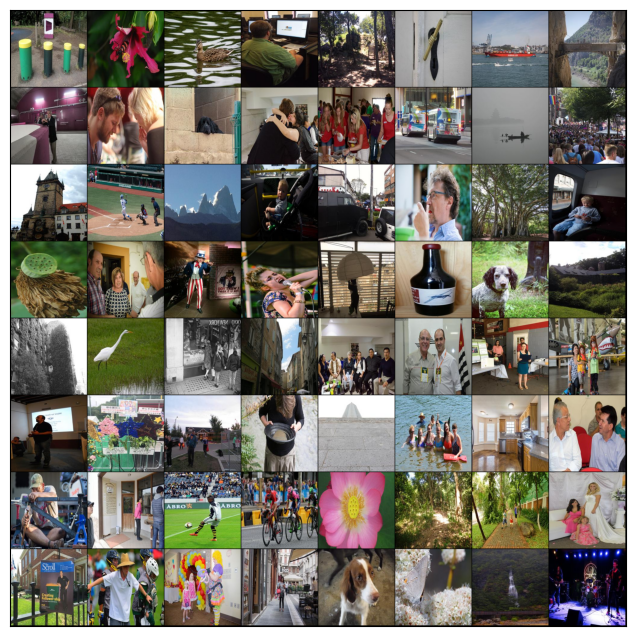

In [38]:
show_batch(train_dl)

### Using GPU

In [39]:
def get_default_device():
    '''Pick GPU if available'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    '''Move tensors to chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True).to(torch.float32)

In [40]:
class DeviceDataLoader():
    def __init__(self, dl ,device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [43]:
print(len(train_dl))
print(len(valid_dl))

132
16


### Model and Loss

In [44]:
loss_fn = RegRankLoss(margin=0.02)

In [45]:
model = RegressionNetwork(backbone='resnet18', num_attributes=12, pretrained=True)
model = model.to('cuda')

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

In [46]:
opt = torch.optim.SGD(params=model.parameters(), lr=0.0001, momentum=0.9)

if load:
    print("Loading checkpoint...")

    checkpoint = torch.load(ckpt)
    last_epoch = checkpoint['epoch']

    train_losses = checkpoint['train_losses']
    train_losses_reg = checkpoint['train_losses_reg']
    train_losses_rank = checkpoint['train_losses_rank']
    val_losses = checkpoint['val_losses']

    loss = train_losses[-1]
    loss_reg = train_losses_reg[-1]
    loss_rank = train_losses_rank[-1]

    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['optimizer'])
    model.eval()

else:
    last_epoch = 0

    train_losses = []
    train_losses_reg = []
    train_losses_rank = []
    val_losses = []

for epoch in range(last_epoch, epochs):

    # Training Phase
    model.train()

    pbar = tqdm(enumerate(train_dl), total=len(train_dl))
    for batch, (x, y) in pbar:

        opt.zero_grad()
        x1, x2 = torch.split(x, 32, dim=0)
        y1, y2 = torch.split(y, 32, dim=0)

        y_pred1 = model(x1)
        y_pred2 = model(x2)
        loss, loss_reg, loss_rank = loss_fn(y_pred=(y_pred1, y_pred2),y_true=(y1, y2))
        loss.backward()
        opt.step()

        pbar.set_description("Epoch {}, Reg Loss: {:.4f}, Rank Loss: {:.4f} ".format(
            epoch, float(loss_reg), float(loss_rank)))
    train_losses.append(loss)
    train_losses_reg.append(loss_reg)
    train_losses_rank.append(loss_rank)


    # Evaluation Phase
    model.eval()
    test_loss = 0.0
    pbar = tqdm(enumerate(valid_dl), total=len(valid_dl))
    for batch, (x, y) in pbar:

        with torch.no_grad():
            y_pred = model(x)
            test_loss += F.mse_loss(y_pred, y)

    test_loss /= len(valid_dl)
    val_losses.append(test_loss)
    filename = "{}_epoch_{}_loss_{:.4f}_.pt".format('AADB', epoch, test_loss)
    torch.save({'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': opt.state_dict(),
                'train_losses': train_losses,
                'train_losses_reg': train_losses_reg,
                'train_losses_rank': train_losses_rank,
                'val_losses': val_losses
             },  os.path.join('F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt_2_pretrained', filename))
    load = False

100%|██████████| 16/16 [00:00<00:00, 26.59it/s]


# Evaluation

In [167]:
ckpt = 'F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt_2\AADB_epoch_199_loss_0.0843_.pt'

In [168]:
model = RegressionNetwork(backbone='resnet18', num_attributes=12, pretrained=True)
model = model.to('cuda')
model.load_state_dict(torch.load(ckpt)['model'])
model.eval()

RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [169]:
test_dl = DataLoader(aadb_test, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
test_dl = DeviceDataLoader(test_dl, device)

In [170]:
loss = 0.0 
y_preds = []
with torch.no_grad():
    for batch, (x, y) in tqdm(enumerate(test_dl), total=len(test_dl)):
        y_pred = model(x)
        loss += F.mse_loss(y_pred, y)
        y_preds.append(y_pred)
    
    loss /= len(test_dl)
    y_preds = torch.cat(y_preds, dim=0).cpu().numpy()
    y_preds = np.clip(y_preds, -1.0, 1.0)
    y_preds = np.array([list(np.around(np.array(i), 3)) for i in y_preds])
    
    print("Test Loss: {:.4f}".format(float(loss)))

100%|██████████| 32/32 [00:01<00:00, 24.34it/s]

Test Loss: 0.0929


# Tests

In [171]:
def plot_loss(train_losses, val_losses):
    train_losses_list = [i.item() for i in train_losses]
    val_losses_list = [i.item() for i in val_losses]
    plt.plot(train_losses_list, '-bx')
    plt.plot(val_losses_list, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No. of epochs');
    

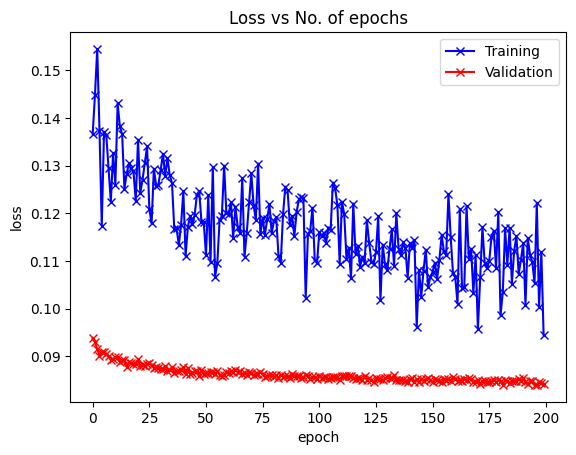

In [172]:
checkpoint = torch.load(ckpt)
train_losses = torch.load(ckpt)['train_losses']
val_losses = torch.load(ckpt)['val_losses']
plot_loss(train_losses, val_losses)

In [2]:
i = random.randint(0, len(aadb_test))
x, y = aadb[i]
x_tensor = x.to("cuda").unsqueeze(0)
y_pred = model(x_tensor)
y_pred = np.clip(y_pred.cpu().detach().numpy(), -1.0, 1.0)
y = y.numpy()

NameError: name 'random' is not defined

In [ ]:
display_aesthetics(x, y, y_pred, interval=[-0.2, 0.2], score=True)